# Beer Quality Score Regression Model
by [Leonardo Maggio 292938](mailto:s292938@studenti.polito.it)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import csv
import re
import copy
from matplotlib.ticker import PercentFormatter

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw
from sklearn.feature_extraction import text
from scipy.sparse import csr_matrix, hstack

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from lightgbm import LGBMRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

# Overview
- [Data Preprocessing](#1.-Data-Preprocessing)
    - [Getting the Data](#1.1-Getting-the-Data)
    - [Cleaning the Data](#1.2-Data-Cleaning)
    - [Feature Encoding](#1.3-Feature-Encoding)
- [Model Selection](#2.-Model-Selection)
    - [Hyperparameters Tuning](#2.1-Hyperparameters-Tuning)
    - [Ensembling](#2.2-Ensembling)

## 1. Data Preprocessing
### 1.1 Getting the Data

In [2]:
df = pd.read_csv('development.tsv', sep='\t', encoding='utf-8')
eval_df = pd.read_csv('evaluation.tsv', sep='\t', encoding='utf-8')

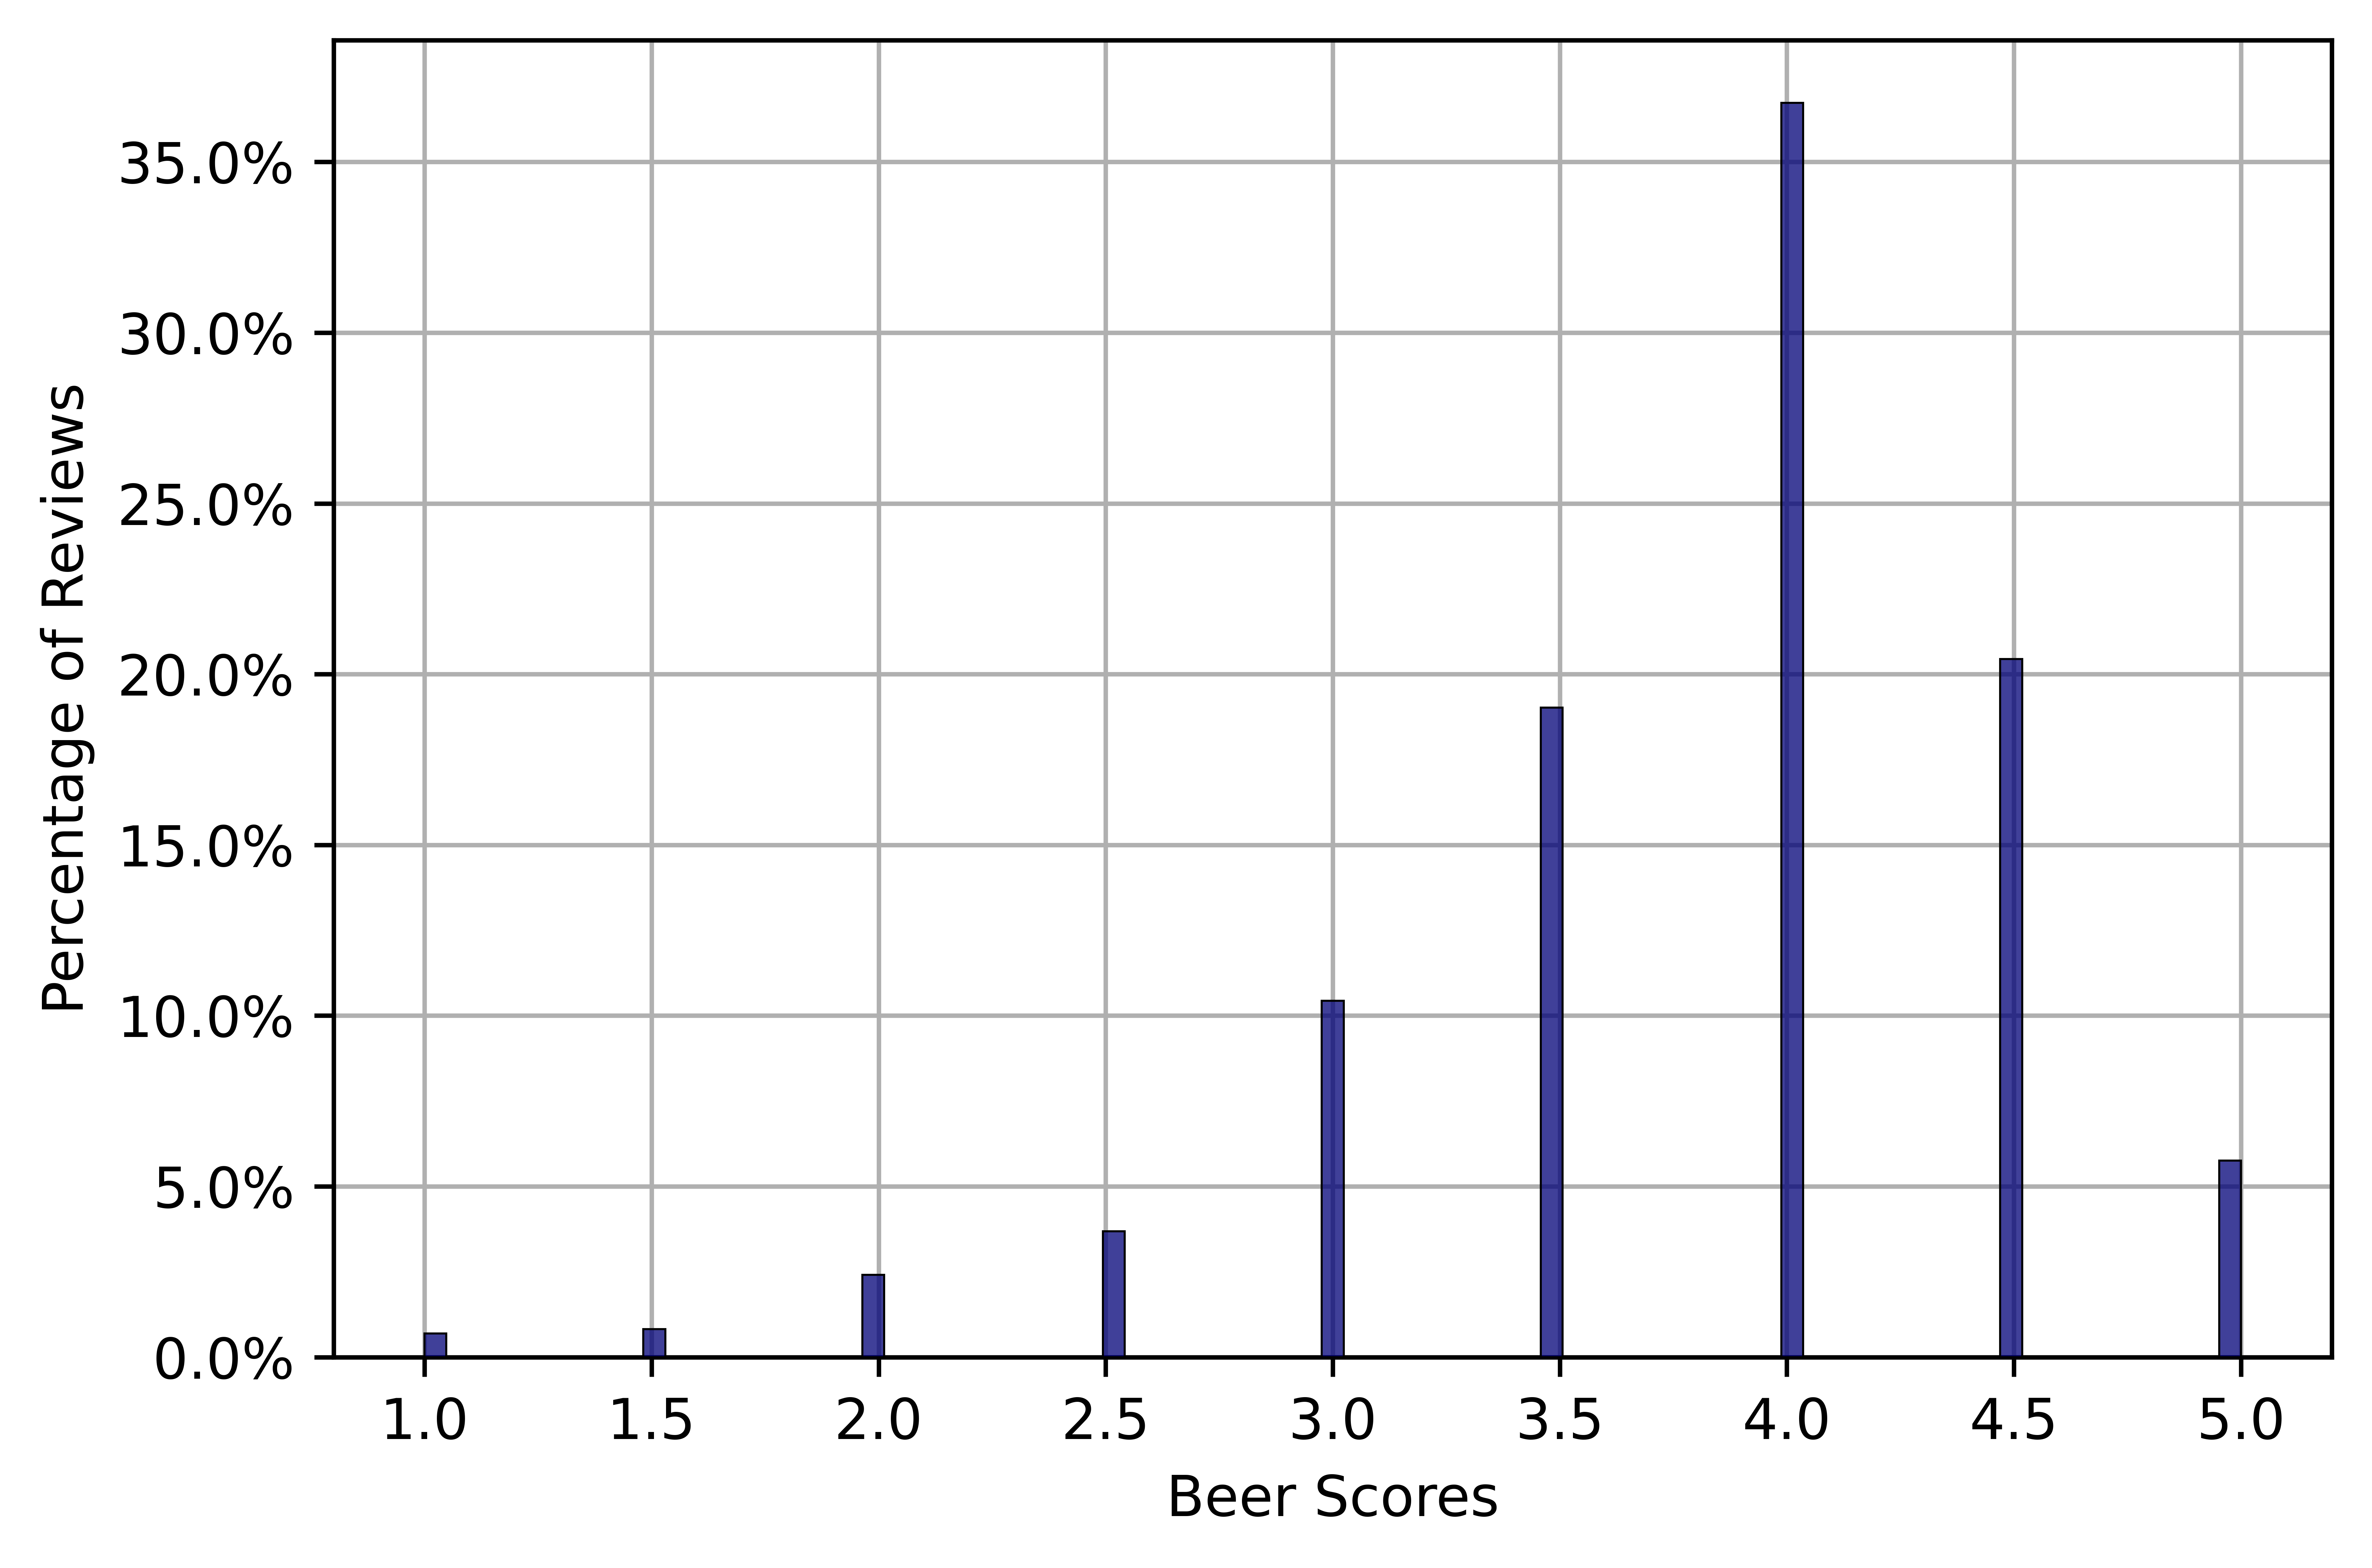

In [3]:
plt.figure(dpi=1200)
plt.grid(True)
ax = sns.histplot(data=df['review/overall'], stat='probability', color='#007', zorder=3)
#ax.set_title('Beer Scores Distribution')
ax.set(xlabel = "Beer Scores", ylabel = "Percentage of Reviews")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.tight_layout()
plt.savefig("Plots/beer_scores_distribution.pdf")  
plt.show()

### 1.2 Data Cleaning

#### 1.2.1 Dealing with missing values

##### Distribution of the missing values

In [4]:
df.isna().sum()

beer/ABV              3107
beer/name                0
beer/style               0
review/appearance        0
review/aroma             0
review/overall           0
review/palate            0
review/taste             0
review/text             18
user/ageInSeconds    55355
user/birthdayRaw     55355
user/birthdayUnix    55355
user/gender          41819
user/profileName        14
dtype: int64

In [5]:
df.nunique()

beer/ABV               336
beer/name            14770
beer/style             104
review/appearance        9
review/aroma             9
review/overall           9
review/palate            9
review/taste             9
review/text          69975
user/ageInSeconds     1952
user/birthdayRaw      1882
user/birthdayUnix     1882
user/gender              2
user/profileName     10573
dtype: int64

In [6]:
eval_df.isna().sum()

beer/ABV              1285
beer/name                0
beer/style               0
review/appearance        0
review/aroma             0
review/palate            0
review/taste             0
review/text              4
user/ageInSeconds    23728
user/birthdayRaw     23728
user/birthdayUnix    23728
user/gender          17870
user/profileName         3
dtype: int64

In [7]:
eval_df.nunique()

beer/ABV               292
beer/name             9305
beer/style             104
review/appearance        9
review/aroma             9
review/palate            9
review/taste             9
review/text          29995
user/ageInSeconds     1416
user/birthdayRaw      1368
user/birthdayUnix     1368
user/gender              2
user/profileName      7271
dtype: int64

##### Filling `beer/ABV` missing values
Since beers of the same style have similar alcohol concentrations, we have decided to fill in the missing values of `beer/ABV` with the `beer/ABV` median of the respective style.

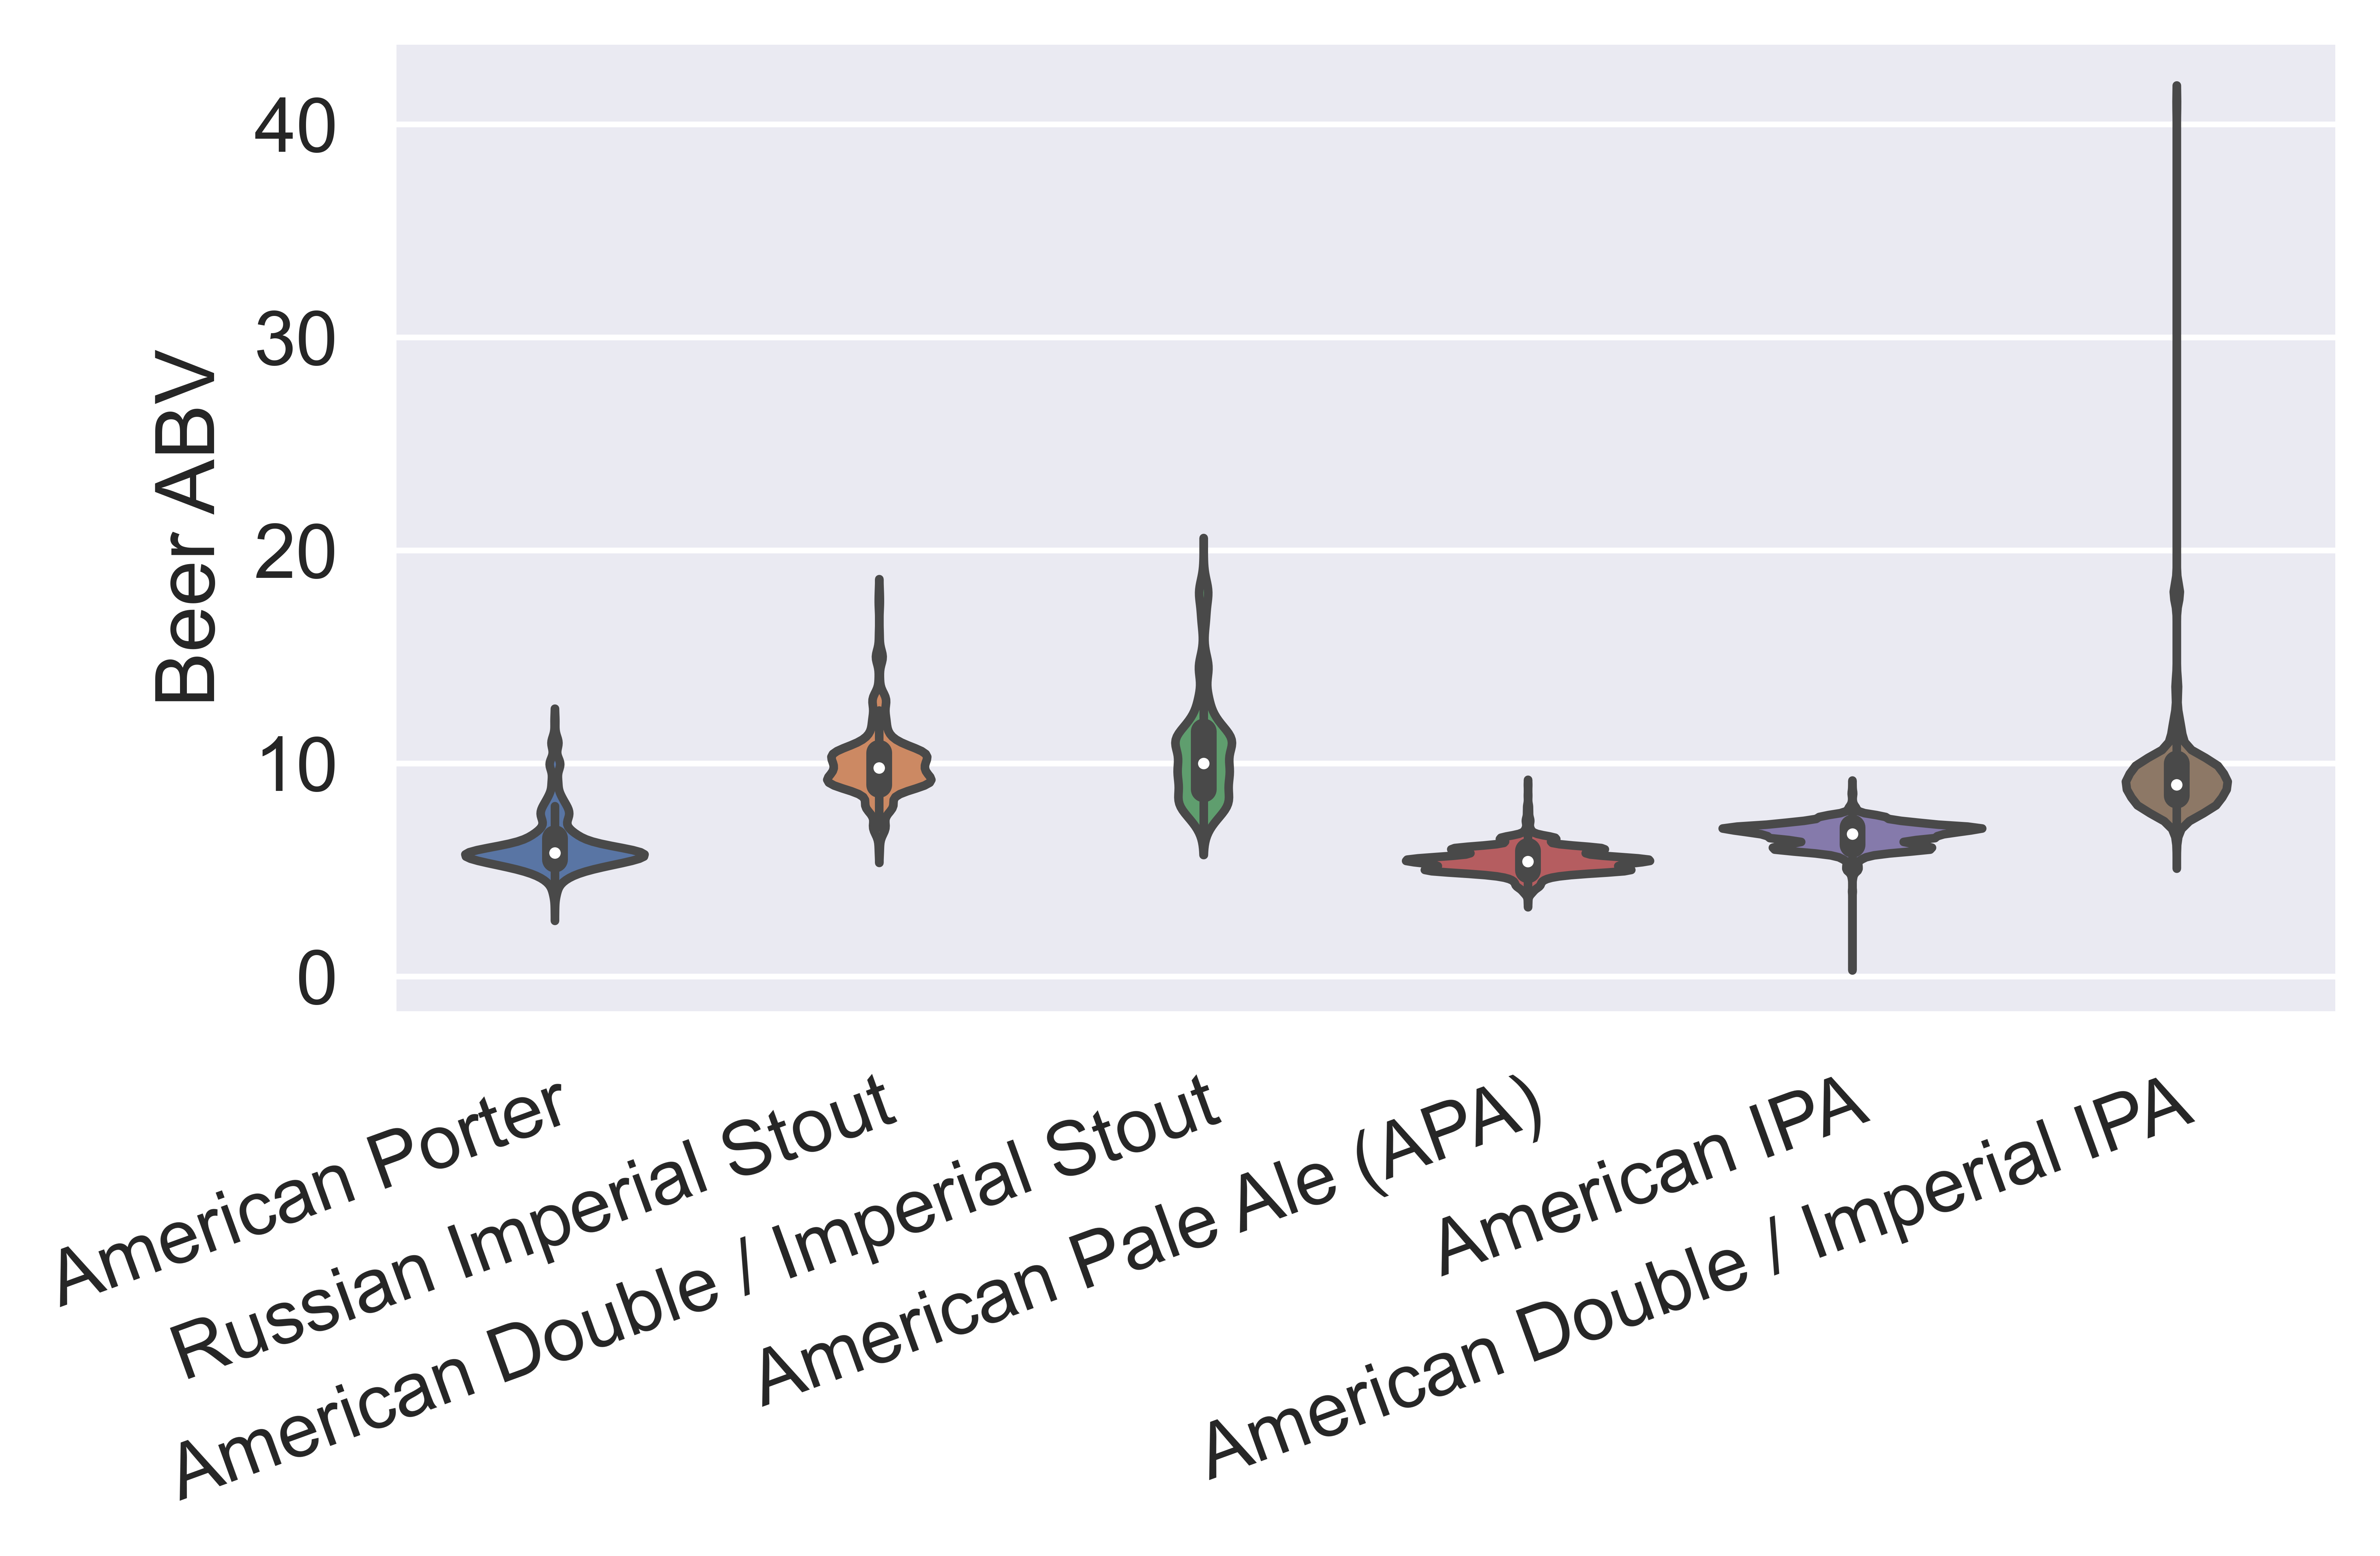

In [8]:
plt.figure(dpi=1200)
abv_by_style = df[['beer/ABV', 'beer/style']].dropna(how='any')
abv_by_style = abv_by_style.groupby('beer/style').filter(lambda x: (x['beer/style'].count() >= 2000))

sns.set(font_scale=1.2)
ax = sns.violinplot(x='beer/style', y ='beer/ABV', data=abv_by_style)
#ax.set_title('Beer ABV by Style')
ax.set(xlabel = "", ylabel = "Beer ABV")
ax.set_xticklabels(ax.get_xticklabels(),rotation=20,ha="right",rotation_mode='anchor')
plt.tight_layout()
plt.savefig("Plots/beerABV_by_style.pdf")
plt.show()

In [9]:
df['beer/ABV'] = df.groupby('beer/style').transform(lambda x: x.fillna(x.median()))
eval_df['beer/ABV'] = eval_df.groupby('beer/style').transform(lambda x: x.fillna(x.median()))

##### Discarding meaningless user-related features
User-related features have several related missing values, which in any case are insignificant.

In [10]:
df.drop(['user/ageInSeconds', 'user/birthdayRaw', 'user/birthdayUnix', 'user/gender'], inplace=True, axis=1)
eval_df.drop(['user/ageInSeconds', 'user/birthdayRaw', 'user/birthdayUnix', 'user/gender'], inplace=True, axis=1)

##### Filling missing reviews and usernames

In [11]:
df['review/text'] = df['review/text'].fillna('other')
df['user/profileName'] = df['user/profileName'].fillna('other')
eval_df['review/text'] = eval_df['review/text'].fillna('other')
eval_df['user/profileName'] = eval_df['user/profileName'].fillna('other')

#### 1.2.2 Dealing with duplicates
Each entry should refer to a review of a beer by a connoisseur. If a user has rated the same beer more than once, then only keep the first.

In [12]:
df.shape

(70000, 10)

In [13]:
df = df.drop_duplicates(subset=['user/profileName', 'beer/name'], keep='first')

In [14]:
df.shape

(69942, 10)

### 1.3 Feature Encoding
#### 1.3.1 Text Processing

In [15]:
class LemmaTokenizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def __call__(self, document):
        lemmas = []        
        for t in word_tokenize(document):
            t = t.strip() # remove spaces at the beginning/end 
            t = t.lower() # lowercase
            t = re.sub(r'[^\w\s]','',t) # remove punctuation and symbols   
            t = re.sub(r'[\d+]','',t) # remove numbers          
            lemma = self.lemmatizer.lemmatize(t)
            if len(lemma) > 2:
                lemmas.append(lemma)    
        return lemmas

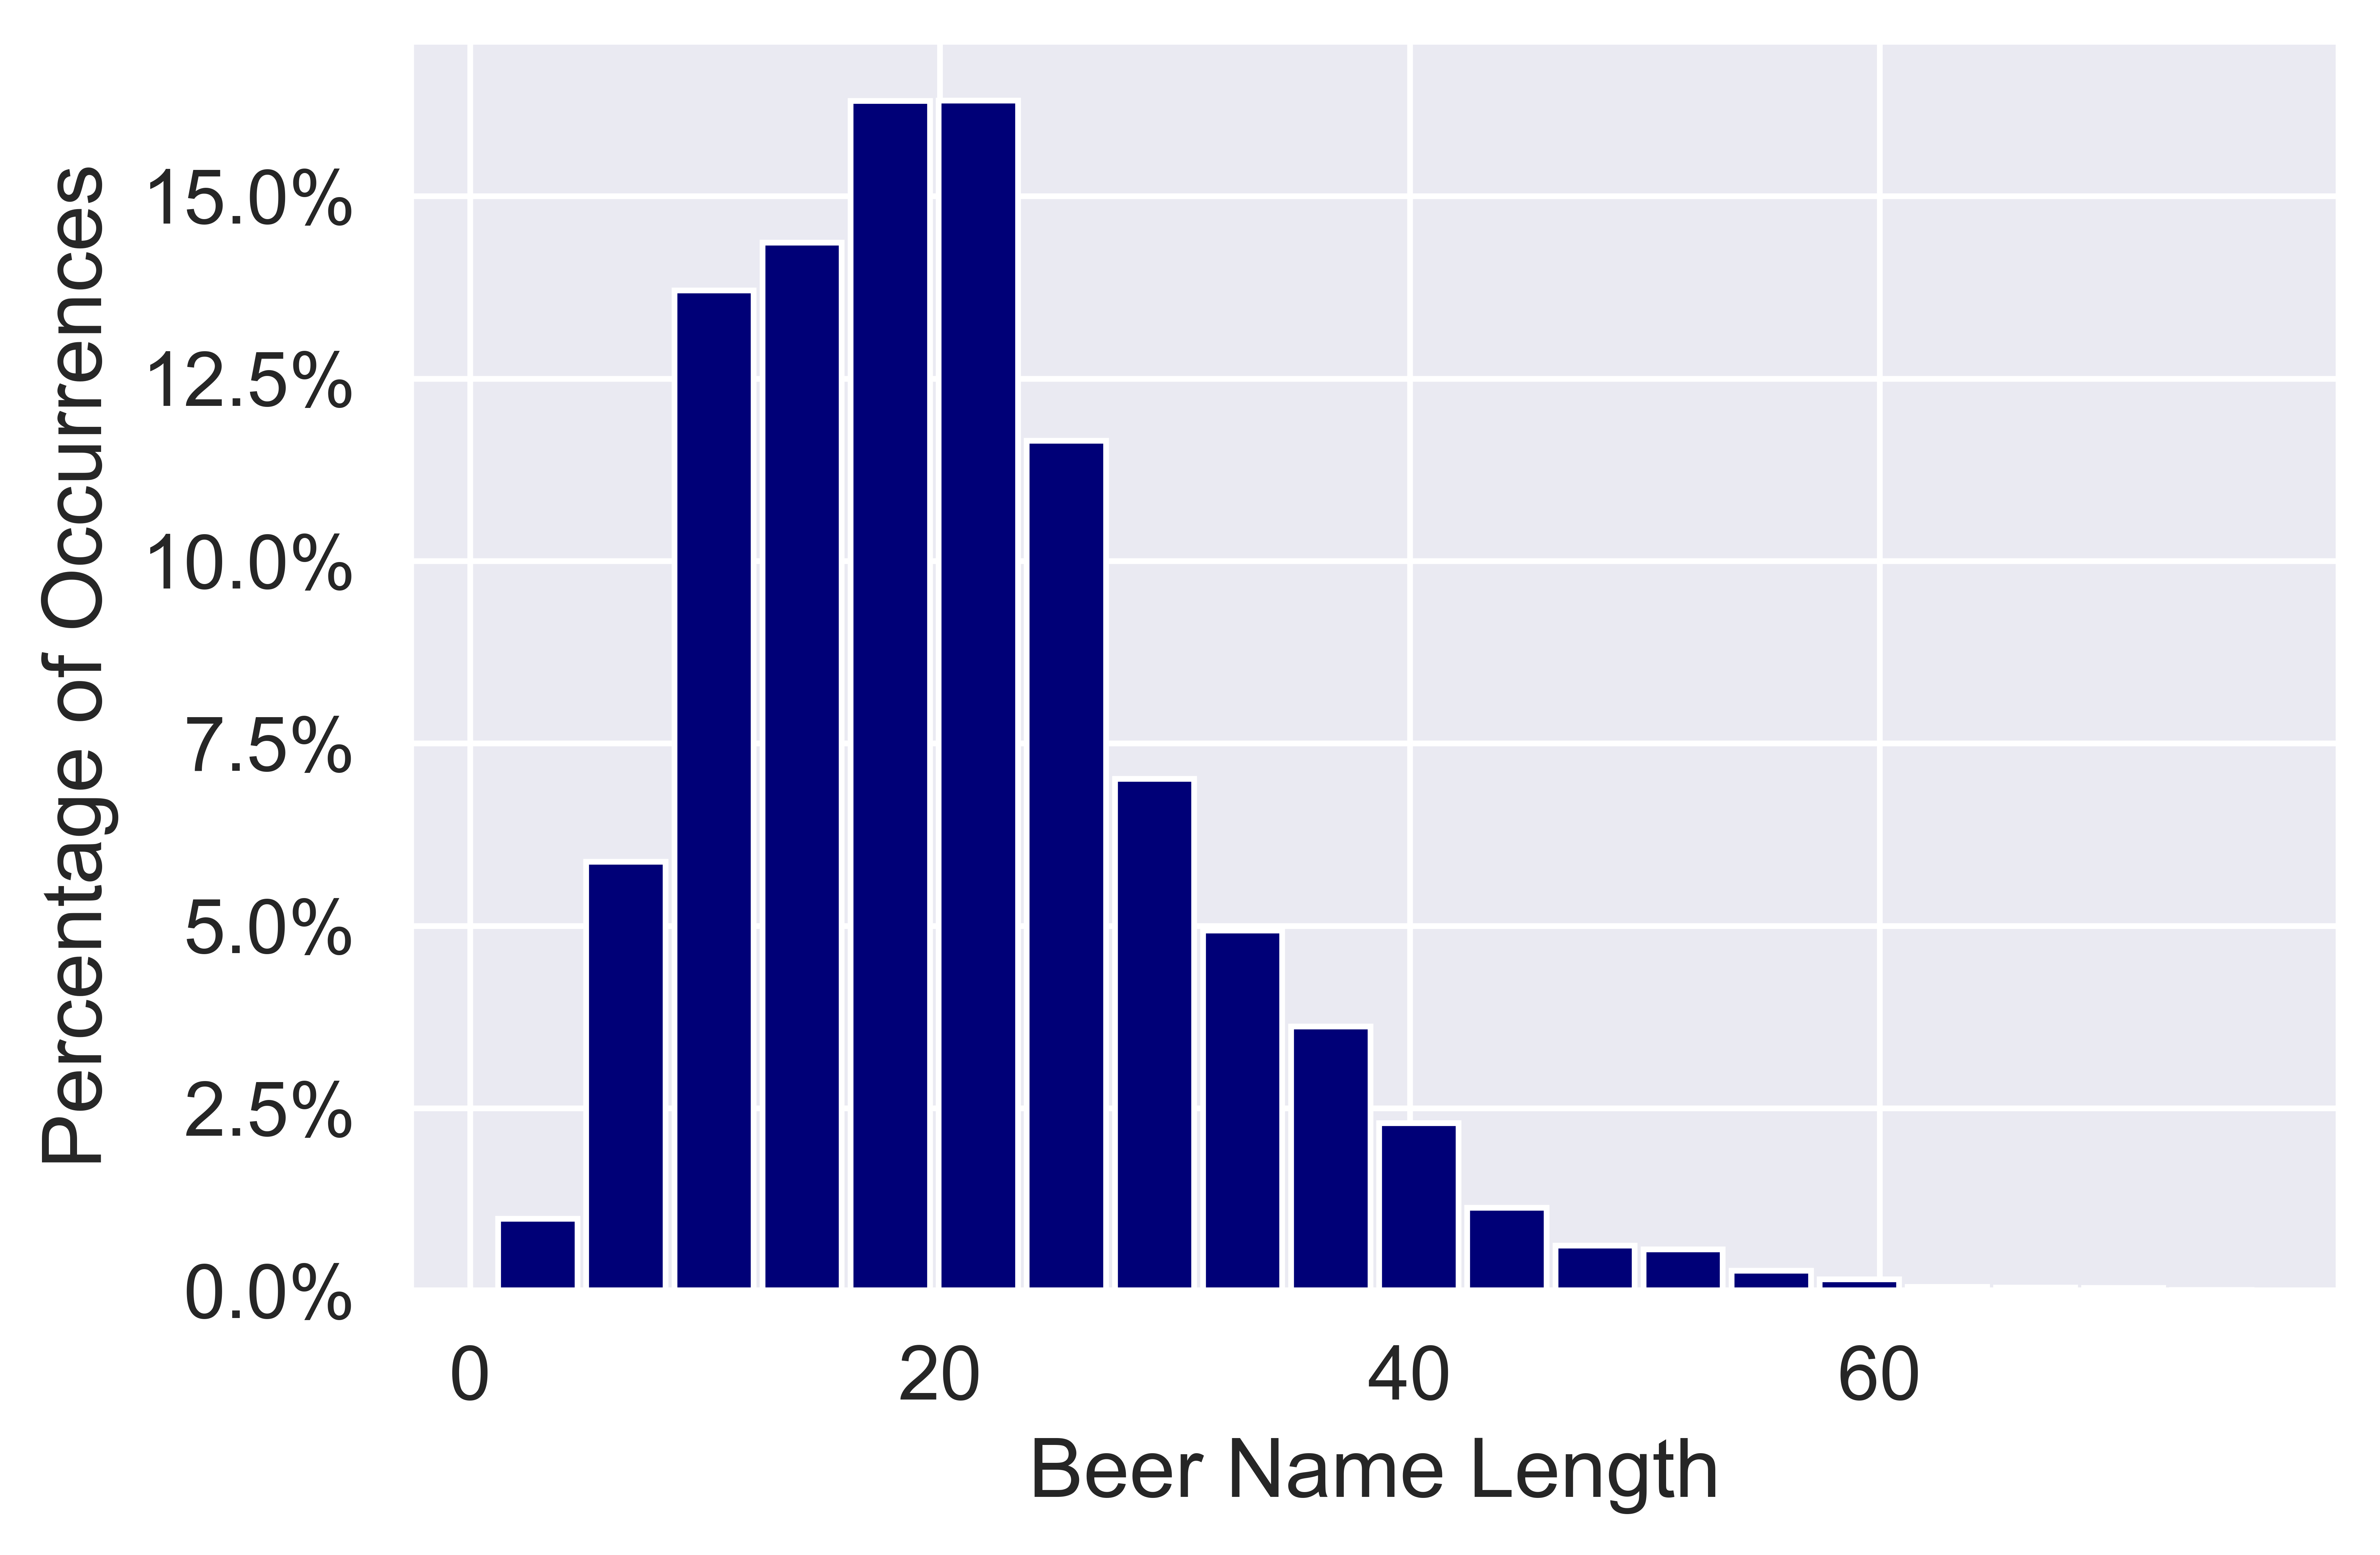

In [16]:
plt.figure(dpi=1200)
temp = df[['beer/name']].copy()
temp['name_length'] = temp['beer/name'].apply(lambda x : len(x))
w = (np.ones(len(temp['name_length'])) / len(temp['name_length']))
h = plt.hist(temp['name_length'], bins=20, weights = w, zorder=2, rwidth=0.9, color='#007')
plt.xlabel('Beer Name Length')
plt.ylabel('Percentage of Occurrences')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.tight_layout()
plt.savefig("Plots/beer_names_distribution.pdf")
plt.show()

In [17]:
y = df['review/overall']

train_review = df['review/text']
eval_review = eval_df['review/text']
train_name = df['beer/name']
eval_name = eval_df['beer/name']

df.drop(['beer/name', 'review/text', 'review/overall'], inplace=True, axis=1)
eval_df.drop(['beer/name', 'review/text'], inplace=True, axis=1)

In [18]:
vectorizer = TfidfVectorizer(ngram_range=(1, 4), tokenizer=LemmaTokenizer(), stop_words="english")
train_tfidf_review = vectorizer.fit_transform(train_review)
eval_tfidf_review = vectorizer.transform(eval_review)

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
train_tfidf_name = vectorizer.fit_transform(train_name)
eval_tfidf_name = vectorizer.transform(eval_name)

#### 1.3.2 Handling Categorical Data

In [19]:
training = len(df)
concatenation = pd.concat([df, eval_df])

In [20]:
dummies = pd.get_dummies(concatenation)
x = dummies[:training]
x_test = dummies[training:]

In [21]:
x = csr_matrix(x)
x_test = csr_matrix(x_test)

In [22]:
approach = 'all_data'

if approach == 'no_name':
    x = hstack([x, train_tfidf_review])
    x_test = hstack([x_test, eval_tfidf_review])
elif approach == 'all_data':
    x = hstack([x, train_tfidf_review, train_tfidf_name])
    x_test = hstack([x_test, eval_tfidf_review, eval_tfidf_name])

## 2. Model Selection

In [23]:
def save_predictions(y_pred, directory):
    with open(directory, mode='w') as file:
        writer = csv.writer(file, delimiter=',',lineterminator='\r', quotechar='"', quoting=csv.QUOTE_NONE)
        writer.writerow(['Id', 'Predicted'])  
        for i in range(len(y_pred)):
            writer.writerow([i, y_pred[i]])

### 2.1 Hyperparameters Tuning

In [24]:
def doGridSearchAllData(model, hyperparameters):
    
    gs = GridSearchCV(estimator = model,
                      param_grid = hyperparameters,
                      scoring='r2',
                      cv=5, 
                      n_jobs=-1,
                      verbose=True)
    gs.fit(x, y)
    print(f"Best parameters:\t{gs.best_params_}")
    print(f"Best score:\t{gs.best_score_}")   
    return gs

#### 2.1.1 Linear Regression

In [ ]:
# Best parameters:	{'fit_intercept': True, 'normalize': False}
# Best score:	0.6762063290330096 noname
# Best score:	0.6717380769034367 all

hyperparameters_LR = {
    'fit_intercept' : [True, False],
    'normalize' : [True, False]
    #'fit_intercept' : [True],
    #'normalize' : [False]
}

lr_best = doGridSearchAllData(LinearRegression(), hyperparameters_LR)
pred_lr = lr_best.predict(x_test)

In [ ]:
save_predictions(pred_lr, 'lr_best_cv5_alldata.csv')

#### 2.1.2 Ridge Regression

In [ ]:
# Best parameters:	{'alpha': 10.0}
# Best score:	0.6967913009351479 noname
# Best score:	0.6962477784303427 all

hyperparameters_Ridge = {
    'alpha' : [.1, 1e0, 1e1, 1e2]
    #'alpha' : [1e1]
}

ridge_best = doGridSearchAllData(Ridge(), hyperparameters_Ridge)
pred_ridge = ridge_best.predict(x_test)

In [ ]:
save_predictions(pred_ridge, 'ridge_best_cv5_alldata.csv')

#### 2.1.3 Linear Support Vector Regression

In [ ]:
# Best parameters:	{'C': 0.1, 'loss': 'squared_epsilon_insensitive'}
# Best score:	0.698592590948652 noname
# Best score:	0.6956093906332712 all

hyperparameters_LSVR = {
    'C' : [.1, 1e0, 1e1, 1e2],
    'loss' : ['epsilon_insensitive', 'squared_epsilon_insensitive']
    #'C' : [.1],
    #'loss' : ['squared_epsilon_insensitive']    
}

lsvr_best = doGridSearchAllData(LinearSVR(), hyperparameters_LSVR)
pred_lsvr = lsvr_best.predict(x_test)

In [ ]:
save_predictions(pred_lsvr, 'lsvr_best_cv5_alldata.csv')

#### 2.1.4 LightGBM Regression

In [ ]:
# Best parameters:	{'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 31}
# Best score:	0.7100433816952192 noname
# Best score:	0.7099976346904298 all

hyperparameters_LGBMR = {
    'n_estimators' : [100, 200, 300],
    'min_child_samples' : [10, 20, 50],
    'num_leaves' : [31, 62, 124]
    #'n_estimators' : [200],
    #'min_child_samples' : [20],
    #'num_leaves' : [31]
}

lgbmr_best = doGridSearchAllData(LGBMRegressor(), hyperparameters_LGBMR)
pred_lgbmr = lgbmr_best.predict(x_test)

In [ ]:
save_predictions(pred_lgbmr, 'lgbmr_best_cv5_alldata.csv')

### 2.2 Ensembling

In [ ]:
lgbmr_vote = LGBMRegressor(**lgbmr_best.best_params_)
ridge_vote = Ridge(**ridge_best.best_params_)
lsvr_vote = LinearSVR(**lsvr_best.best_params_)

In [ ]:
vr = VotingRegressor([('lgbmr', lgbmr_vote),
                      ('ridge', ridge_vote),
                      ('lsvr', lsvr_vote)])
vr.fit(x,y)
pred_vr = vr.predict(x_test)

In [ ]:
save_predictions(pred_vr, 'ensemble_best_cv5_alldata.csv')